# Generate ONL DVH curves

This notebook contains code that generates the DVH curves reported in Figure 3. 

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import seaborn as sns
import SimpleITK as sitk
import matplotlib.backends.backend_pdf
import pandas as pd

In [38]:
def get_3D_Dose_dif(pred, gt, possible_dose_mask=None):
    if possible_dose_mask is not None:
        pred = pred[possible_dose_mask > 0]
        gt = gt[possible_dose_mask > 0]

    dif = np.mean(np.abs(pred - gt))
    return dif

def volumetric_dice(img, mask):
    img[img > 1] = 1
    img[img < 1] = 0
    mask[mask > 1] = 1
    mask[mask < 1] = 0
    return np.sum(mask[img == mask]) * 2.0 / (np.sum(img)+np.sum(mask))

In [39]:
root_path = "/Users/amithkamath/repo/deepdosesens"
data_path = os.path.join(root_path, "data", "processed-ONL")
pred_path = os.path.join(root_path, "data", "output-ONL", "output-ONL-6", "Prediction")
results_path = os.path.join(root_path, "results")

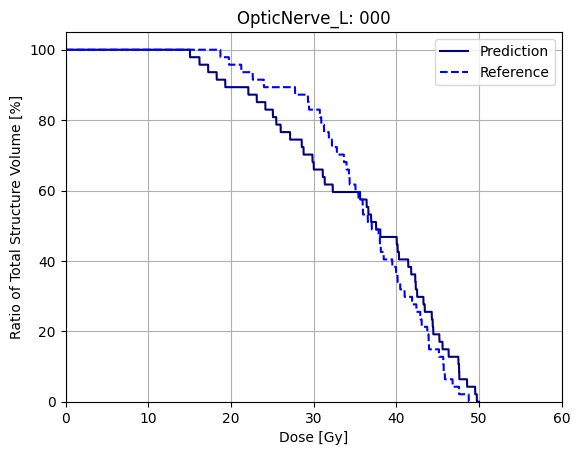

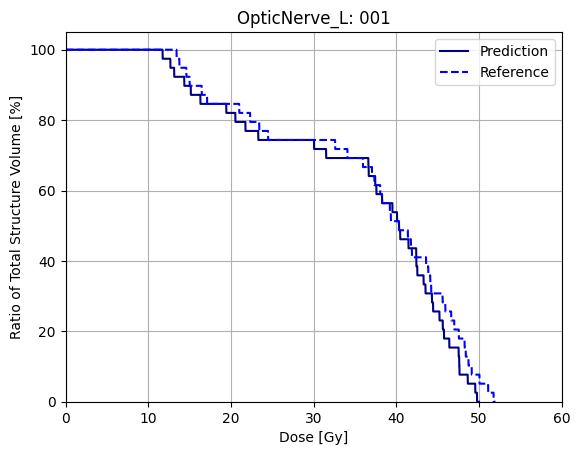

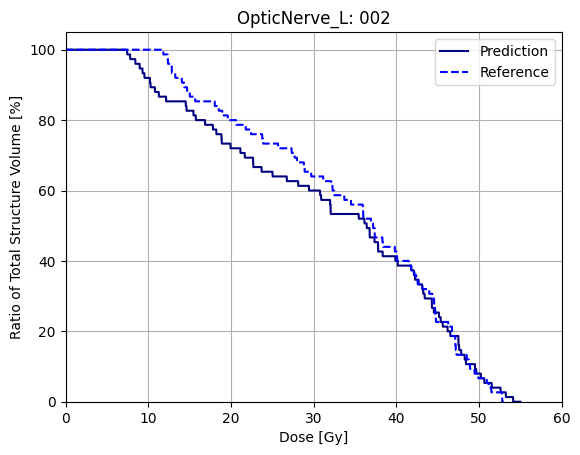

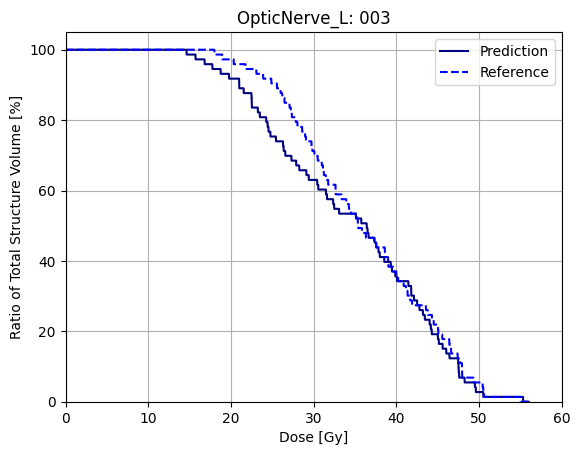

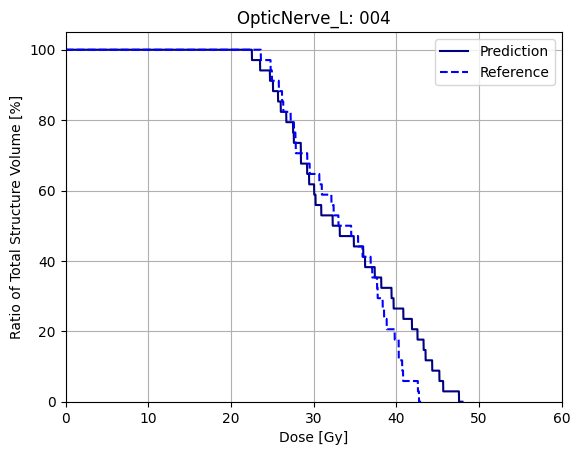

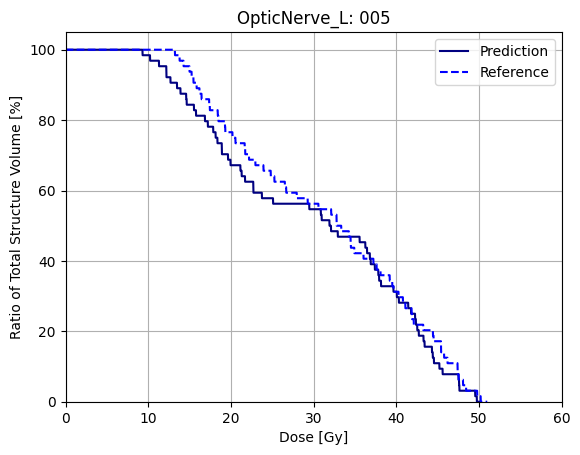

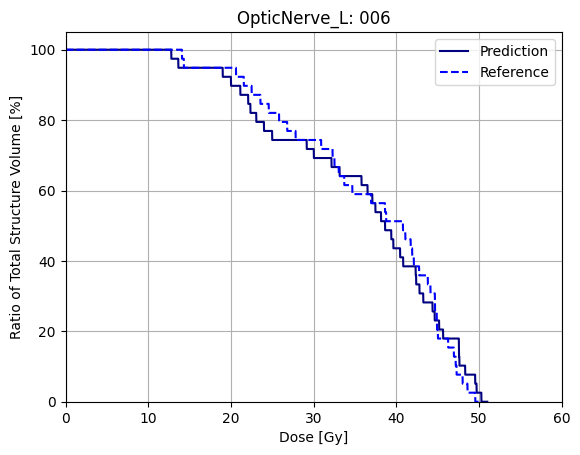

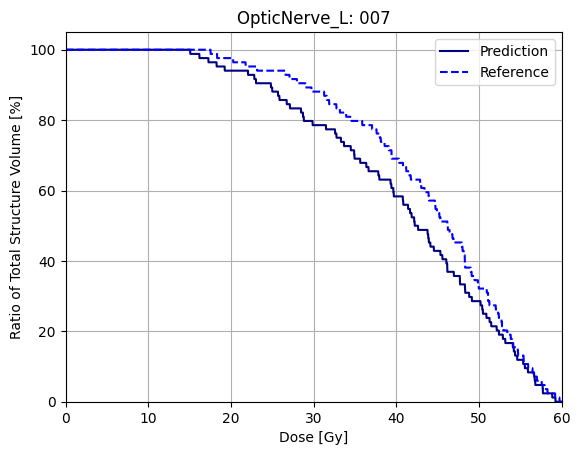

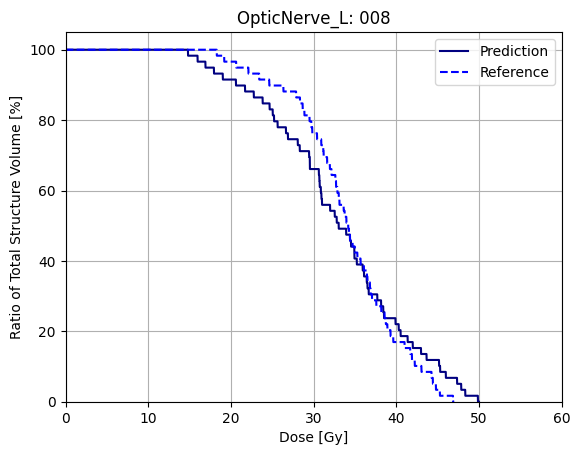

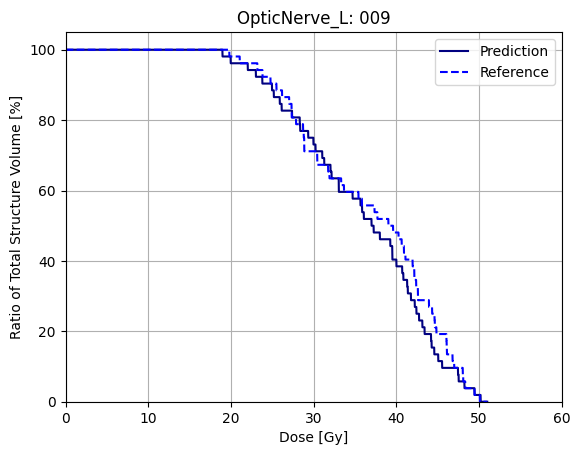

In [40]:
pdf = matplotlib.backends.backend_pdf.PdfPages(os.path.join(results_path,"3_ONL_DVH_variations.pdf"))

# select all cases in the folder
cases = sorted(glob.glob(os.path.join(pred_path, "*")))

# define a list to store the dataframes for the dose metrics
frames_oars = []
frames_targets = []
case_names = []

base_structure = sitk.ReadImage(os.path.join(data_path, "DLDP_000", "OpticNerve_L.nii.gz"))
base_mask = sitk.GetArrayFromImage(base_structure)

dsc_list = []
dose_score_list = []

for case in cases:
    # select the case number
    case_nr = case.split("/")[-1]
    #if ("1" in case_nr) or ("3" in case_nr) or ("5" in case_nr) or ("7" in case_nr) or ("9" in case_nr):
    #    continue

    case_names.append(case_nr)
    
    # select and read the ground truth dose
    dose_gt_path = glob.glob(os.path.join(data_path, case_nr) + "/Dose.nii.gz")
    dose_gt = sitk.ReadImage(dose_gt_path[0])
    dose_gt = sitk.GetArrayFromImage(dose_gt)
    
    # select and read the predicted dose
    dose_pred_path = glob.glob(os.path.join(pred_path, case_nr) + "/Dose.nii.gz")
    dose_pred = sitk.ReadImage(dose_pred_path[0])
    dose_pred = sitk.GetArrayFromImage(dose_pred)
    
    # select all the structures in the folder
    structure = os.path.join(data_path, case_nr) + "/OpticNerve_L.nii.gz"
    
    # define a list to store the dose metrics for the targets and oars
    oars = []
    targets = []
    
    # turn structure into a boolean mask
    struct = sitk.ReadImage(structure)
    mask = sitk.GetArrayFromImage(struct)
    mask = np.array(mask, dtype='bool')
    
    dsc = volumetric_dice(base_mask, mask)
    dsc_list.append(dsc)

    # Select all the dose values of the structures voxels
    dose_array_gt = np.array(dose_gt[mask])
    dose_array_pred = np.array(dose_pred[mask])
    
    dose_score = get_3D_Dose_dif(dose_pred, dose_gt, possible_dose_mask=mask)
    dose_score_list.append(dose_score)

    # perform OAR metrics
    max_dose_gt = np.max(dose_array_gt) 
    max_dose_pred = np.max(dose_array_pred)
    max_dose_1pct_gt = np.sort(dose_array_gt)[round(len(dose_array_gt)*0.99)-1]
    max_dose_1pct_pred = np.sort(dose_array_pred)[round(len(dose_array_pred)*0.99)-1]
    mean_dose_gt = np.mean(dose_array_gt)
    mean_dose_pred = np.mean(dose_array_pred)
    # safe all oar metrics in a list
    oars.append([name, max_dose_gt, max_dose_pred, max_dose_1pct_gt,
                    max_dose_1pct_pred, mean_dose_gt, mean_dose_pred])
    
    # calculate the DVHs
    bins_gt = np.arange(0, np.ceil(np.max(dose_array_gt)), 0.01)
    total_voxels = len(dose_array_gt)
    values_gt = []
    for bin in bins_gt:
        number_gt = (dose_array_gt >= bin).sum()
        value_gt = number_gt/total_voxels * 100
        values_gt.append(value_gt)

    bins_gt = list(bins_gt)
    bins_gt.append(np.ceil(np.max(dose_array_gt)))
    values_gt.append(0.0)

    bins_pred = np.arange(0, np.ceil(np.max(dose_array_pred)), 0.01)
    values_pred = []
    for bin in bins_pred:
        number_pred = (dose_array_pred >= bin).sum()
        value_pred = number_pred/total_voxels * 100
        values_pred.append(value_pred)

    bins_pred = list(bins_pred)
    bins_pred.append(np.ceil(np.max(dose_array_pred)))
    values_pred.append(0.0)

    fig = plt.figure()
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 10))))
    plt.plot(bins_pred, values_pred, label="Prediction")
    plt.plot(bins_gt, values_gt, '--', label="Reference")
    plt.gca().legend(loc='upper right')
    
    # convert the lists containing the dose metrics into dataframes
    OARs_DF = pd.DataFrame(oars, columns = ["structure", "max_dose_gt", "max_dose_pred", "max_dose_1pct_gt",
                                            "max_dose_1pct_pred", "mean_dose_gt", "mean_dose_pred"])
    # save the dataframes of each case into a list
    frames_oars.append(OARs_DF)

    plt.xlabel('Dose [Gy]')
    plt.ylabel('Ratio of Total Structure Volume [%]')
    plt.xlim((0, 60))
    plt.ylim((0, 105))
    plt.title(name + ": " + case_nr[-3:])
    plt.grid()
    pdf.savefig(fig)

pdf.close()

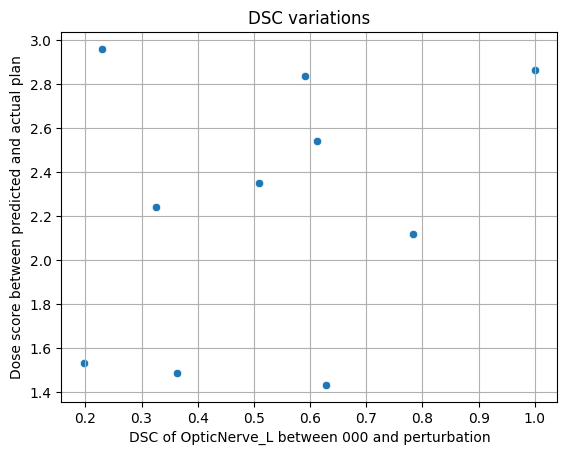

In [41]:
fig = plt.figure()
sns.scatterplot(x=dsc_list, y = dose_score_list)
plt.xlabel('DSC of OpticNerve_L between 000 and perturbation')
plt.ylabel('Dose score between predicted and actual plan')
plt.title("DSC variations")
plt.grid()

In [42]:
dsc_list

[1.0,
 0.627906976744186,
 0.5901639344262295,
 0.7833333333333333,
 0.19753086419753085,
 0.6126126126126126,
 0.32558139534883723,
 0.22900763358778625,
 0.5094339622641509,
 0.36363636363636365]